In [1]:
import torch

from auto_circuit.types import AblationType
from cupbearer import tasks, scripts, utils
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens 

from cupbearer.detectors.extractors.eap_extractor import EAPFeatureExtractor, inverse_tokens

from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.utils import set_model

In [2]:
task_name = "ifelse"
model_name = "pythia-70m"
device = "cpu"

task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)
set_model(task.model)
effect_tokens = torch.tensor(get_effect_tokens(task_name, task.model))
other_tokens = inverse_tokens(effect_tokens, task.model.tokenizer.vocab_size)


Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


In [3]:
eap_feature_extractor = EAPFeatureExtractor(
    effect_tokens=get_effect_tokens(task_name, task.model),
    model=task.model,
    grad_function="prob",
    answer_function="avg_val",
    ablation_type=AblationType.ZERO,
    abs_value=True,
    integrated_grad_samples=None,
    resid_src=False,
    resid_dest=False,
    attn=True,
    mlp=False
)

In [4]:
eap_feature_extractor.compute_patch_out(task.trusted_data, batch_size=32)

In [5]:
# train detector
from cupbearer.detectors.statistical import MahalanobisDetector
detector = MahalanobisDetector(
    feature_extractor=eap_feature_extractor
)

2024-07-18 21:23:54.720 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-07-18 21:23:55.914 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
eap_scores: torch.Size([2880])
  0%|          | 0/64 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


2024-07-18 21:26:06.781 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:343 - AUC_ROC (all): 0.6744
2024-07-18 21:26:06.782 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AP (all): 0.6541


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6744060516357422,
               'AP': 0.6540885437001855}}),
 {'all': <Figure size 640x480 with 1 Axes>})

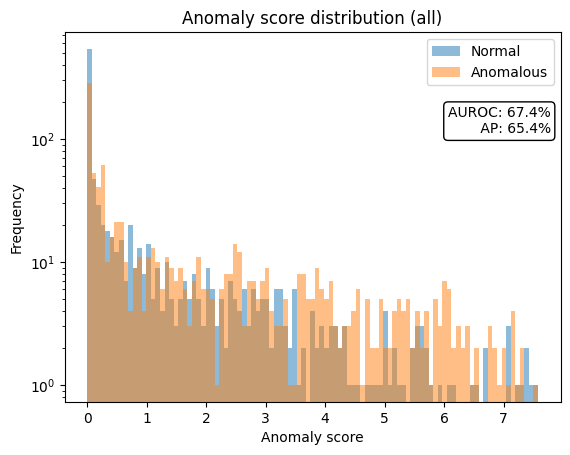

In [6]:
bs = 32
scripts.train_detector(
    task, detector, save_path=None,eval_batch_size=bs
)

In [ ]:
# ok how do I properly filter edges? 

# so, prune scores are organized by dest modules, with dest heads and src nodes
# so, I think it would make sense to pask masks over the dest modules
# to get masks over the dest modules, basically just do the same thresholding thing as with the pruning
# lets see 

In [3]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from torch.utils.data import DataLoader
from kneed import DataGenerator, KneeLocator
from elk_experiments.utils import set_model
from auto_circuit.utils.graph_utils import patchable_model, set_mask_batch_size, train_mask_mode
from cupbearer import utils
from cupbearer.detectors.extractors.eap_extractor import src_ablations, mask_gradient_batch_prune_scores, expand_patch_src_out
model = task.model 
resid_src = False 
resid_dest = False
attn = True
mlp = False

ac_model = patchable_model(
    model, 
    factorized=True, 
    slice_output="last_seq",
    separate_qkv=True, 
    resid_src=False,
    resid_dest=resid_dest,
    attn_src=attn,
    attn_dest=attn,
    mlp_src=mlp,
    mlp_dest=mlp,
    device=device,
    
)
# collect all the prune scores 
    # collect src patch outs 
patch_src_out = src_ablations(
    ac_model, 
    sample=task.trusted_data[0][0],
    ablation_type=AblationType.ZERO,
    device=device
)

batch_size = 32
train_loader = DataLoader(
    task.trusted_data,
    batch_size=batch_size, 
    collate_fn=utils.collate_inputs
)

# get prune scores on batches
with set_mask_batch_size(ac_model, batch_size), train_mask_mode(ac_model):
    prune_scores: dict[str, list[torch.Tensor]] = defaultdict(list)
    for batch in tqdm(train_loader):
        scores_batch = mask_gradient_batch_prune_scores(
            ac_model, 
            batch, 
            patch_src_out=expand_patch_src_out(patch_src_out, batch_size),
            grad_function="prob", 
            answer_function="avg_val",
            effect_tokens=effect_tokens,
            other_tokens=other_tokens,
        )
        for dest_module, scores in scores_batch.items():
            prune_scores[dest_module].append(scores)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
100%|██████████| 64/64 [00:48<00:00,  1.33it/s]


In [4]:
# aggregate 
prune_scores_all = {
    dest_module: torch.cat(scores, dim=0)
    for dest_module, scores in prune_scores.items()
}

prune_scores_mean = {
    dest_module: scores.mean(dim=0)
    for dest_module, scores in prune_scores_all.items()
}

# flatten, sort, find the knee 
prune_scores_flat = torch.cat([scores.flatten() for scores in prune_scores_mean.values()])
prune_scores_abs = torch.abs(prune_scores_flat)
prune_scores_sorted, _ = torch.sort(prune_scores_abs, descending=True)


In [61]:
# use kneedle to find threshold
kneedle = KneeLocator(
    np.arange(len(prune_scores_sorted)), 
    prune_scores_sorted.numpy(), 
    S=1.0, 
    curve="convex", 
    direction="decreasing",
    interp_method="polynomial"
)

threshold = prune_scores_sorted[kneedle.knee]

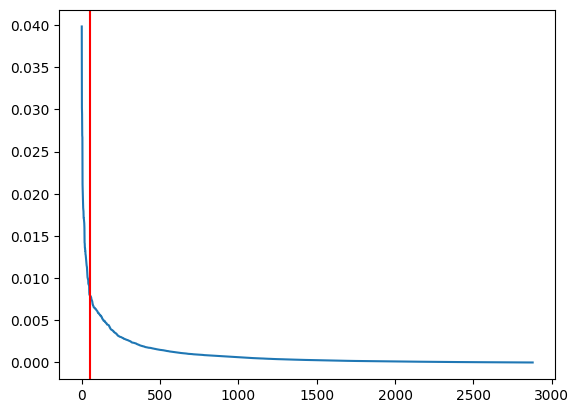

In [62]:
# plot 
import matplotlib.pyplot as plt
plt.plot(prune_scores_sorted.cpu().numpy())
plt.axvline(kneedle.knee, color="red")

In [63]:
x = torch.arange(24).reshape(2, 3, 4)
mask = torch.zeros((3,4))
mask[0, 1] = 1
mask[1, 2] = 1
x[:, mask.bool()], (x * mask.unsqueeze(0)).shape

(tensor([[ 1,  6],
         [13, 18]]),
 torch.Size([2, 3, 4]))

In [64]:
# set x to 0 if less then 5 
mask = prune_scores_flat.abs() > threshold


In [65]:
# use threshold to generate mask dict 
mask_dict = {
    dest_module: (torch.abs(scores) > threshold)
    for dest_module, scores in prune_scores_mean.items()
}


In [66]:
total_edges = sum([mask.sum() for mask in mask_dict.values()])
total_edges

tensor(52)

In [67]:
# apply the mask dict to the prune scores
eap_feature_extractor = EAPFeatureExtractor(
    effect_tokens=get_effect_tokens(task_name, task.model),
    model=task.model,
    grad_function="prob",
    answer_function="avg_val",
    ablation_type=AblationType.ZERO,
    abs_value=True,
    score_mask=None, #mask_dict,
    threshold=threshold,
    integrated_grad_samples=None,
    resid_src=False,
    resid_dest=False,
    attn=True,
    mlp=False
)

In [68]:
eap_feature_extractor.compute_patch_out(task.trusted_data, batch_size=32)

In [69]:
# train detector
from cupbearer.detectors.statistical import MahalanobisDetector
detector = MahalanobisDetector(
    feature_extractor=eap_feature_extractor
)

2024-07-19 18:04:17.778 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-07-19 18:04:18.711 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
eap_scores: torch.Size([2880])
100%|██████████| 64/64 [00:57<00:00,  1.12it/s]


2024-07-19 18:06:18.200 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:343 - AUC_ROC (all): 0.6636
2024-07-19 18:06:18.200 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AP (all): 0.6463


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6635637283325195,
               'AP': 0.6462960302399883}}),
 {'all': <Figure size 640x480 with 1 Axes>})

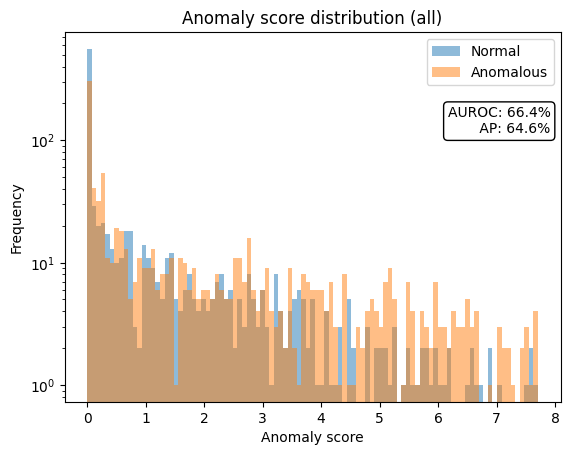

In [70]:
bs = 32
scripts.train_detector(
    task, detector, save_path=None,eval_batch_size=bs
)

In [52]:
detector._means["trusted"]["eap_scores"].shape

torch.Size([2880])